# Self-organizing map

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import susi
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix
import xarray as xr

### Import the raster data and transform to dataframe:

In [45]:
vars_vec = np.array(['HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))
raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1
    
df_raster = stack_data.to_dataframe()[vars_vec] 
rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]
SOM_dat = np.array(df_nona)

## SOM with miniSOM

In [46]:
from minisom import MiniSom
from sklearn import preprocessing as prep
df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona)) # Since SOM uses distance between points, but maybe better to rescale to [0,1]
df_std = df_std.set_axis([vars_vec], axis=1)
SOM_std = np.array(df_std)

In [47]:
gridrows = 25
gridcols = 25
s = 5

som = MiniSom(gridrows,gridcols, 6, learning_rate=0.5, sigma = s, neighborhood_function='gaussian')
# 25x25 grid (rule of thumb to have 5*sqrt(N) nodes, from miniSOM documentation + Karmakar 2017)
# 12 variables
# learning_rate = initial learning rate; at t: learning_rate(t) = learning_rate / (1 + 2t/T)
# sigma = spread of initial neighborhood function; at t: sigma(t) = sigma / (1 + 2t/T)
# gaussian neighborhood function h = exp(-d²/(2*sigma²(t)))
# (It is possible to define other decay functions)
# Use quantization error to optimize hyperparameters?

som.train(SOM_std, 100000)

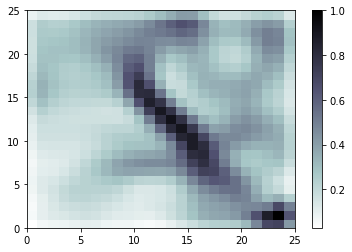

In [48]:
plt.pcolor(som.distance_map(), cmap='bone_r')
plt.colorbar()
plt.show()

### Plot variables on the SOM grid

In [58]:
winners = []

for k in range(SOM_std.shape[0]):
    winners.append(som.winner(SOM_std[k]))

df_std['winner'] = winners   # To map the standardized! values
grouped = df_std.groupby('winner')

ValueError: Grouper for 'winner' not 1-dimensional

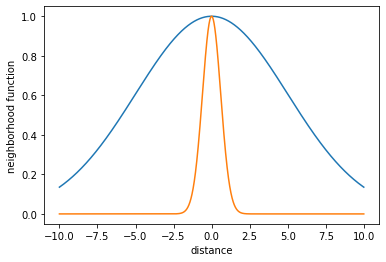

In [6]:
# Visualize neighborhood function

# at start:
sigma_start = s
dist = np.linspace(-10, 10, 10000)
neigh = np.exp(-np.power(dist,2)/(2*sigma_start**2))
plt.plot(dist, neigh)

# at end:
n_iter = 100000
sigma_end = sigma_start / 3
neigh = np.exp(-np.power(dist,2)/ 2*sigma_end**2)
plt.plot(dist, neigh)
plt.xlabel('distance')
plt.ylabel('neighborhood function')
plt.show()

# Neighborhood at the end still too wide?

In [7]:
# Check with data whether these distances are relevant! 
# from scipy.spatial import distance_matrix
# dist = distance_matrix(df_std,df_std)
# pd.DataFrame(dist.flatten()).describe() # largest distance between points = 20, average 4.42, std =2.1

## How to visualize and interprete SOM?

* k-means on the weights --> classification on the original data (Filippi, 2010)
* Plot average values of the variables on the SOM grid (reverse is also possible, visualize other clustering results on the SOM grid)


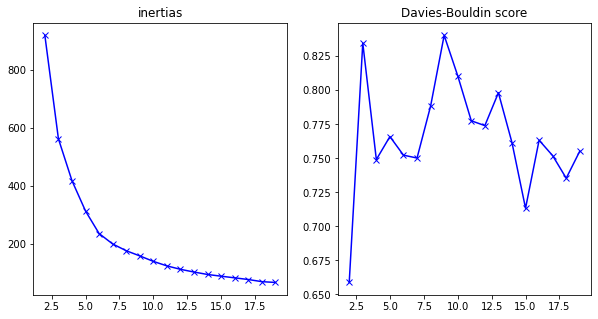

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
neurons = som.get_weights().reshape(gridrows*gridcols,6)
K = range(2,20)
inertias = []
DB_score = []

for k in K:
    clusterSOM = KMeans(n_clusters=k, random_state=0, n_init=5, init='k-means++').fit(neurons)
    inertias.append(clusterSOM.inertia_)
    labs = clusterSOM.labels_
    DB_score.append(davies_bouldin_score(neurons, labs))

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
ax0.plot(K, inertias, 'bx-')
ax0.set_title('inertias')
ax1.plot(K, DB_score, 'bx-')
ax1.set_title('Davies-Bouldin score')
plt.show()

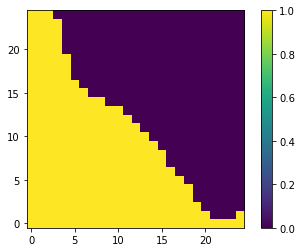

In [12]:
clusterSOM = KMeans(n_clusters=2, random_state=0, n_init=5, init='k-means++').fit(neurons)
clusters = clusterSOM.predict(neurons).reshape(gridrows,gridcols)
plt.imshow(clusters, origin='lower')
plt.colorbar()
plt.show()

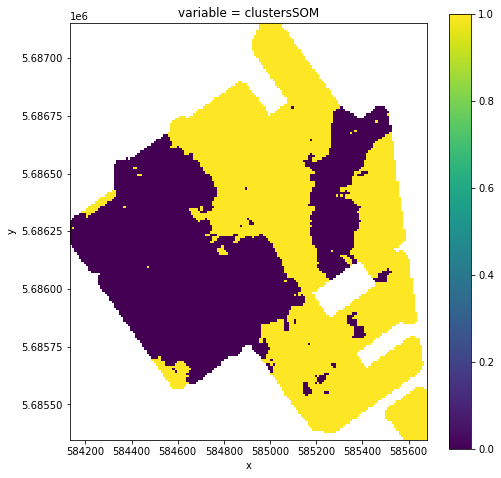

In [13]:
SOM_bmus = np.array(winners)

raster_clusters = np.empty((27540))
raster_clusters[:] = np.nan
raster_clusters[~rows_with_nan] = np.array([clusters[i] for i in winners])


df_raster['clustersSOM'] = raster_clusters 

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='clustersSOM').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

### Map is very variable: different classification + optimal nr of clusters each time the algorithm is executed ==> SOM is not converging with current settings?

## Calculate the DB-score

This allows to compare the classification with that of K-means

In [21]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(SOM_std, raster_clusters[~rows_with_nan])

0.6065855573984769

K-means with 5 clusters has a much higher DB-score!
But the 'optimal' K-means has a lower DB-score